In [1]:
#1. Import the data. Analyse the dimensions of the data. Visualise the data.
# Importing the required dataset
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd "/content/drive/MyDrive/greatlearningdata/"

/content/drive/MyDrive/greatlearningdata


In [4]:
#importing libraries
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In [5]:
paths = glob.glob("train/*")
labels = [os.path.split(x)[-1] for x in paths]

print("Total Number Of labels: {}".format(len(labels)))
print("Labels: {}".format(labels))

Total Number Of labels: 12
Labels: ['Common Chickweed', 'Cleavers', 'Maize', 'Common wheat', 'Loose Silky-bent', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Fat Hen', 'Scentless Mayweed', 'Sugar beet', 'Black-grass', 'Charlock']


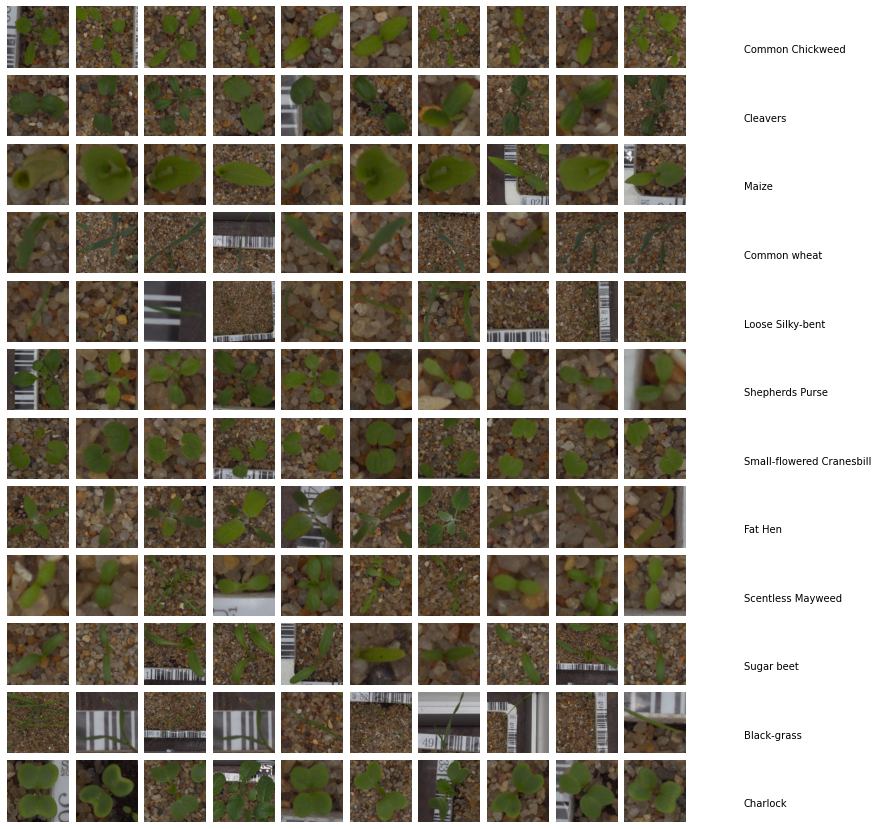

In [6]:
#Exploring the data
fig_r = plt.figure(1, (20, 15))
grid_r = ImageGrid(fig_r, 111, nrows_ncols=(12, 10), axes_pad=0.1)

n_img_class_r = []
counter_1 = 0
for idx, label_1 in enumerate(labels):
    paths = glob.glob(os.path.join("train", label_1, "*.png"))
    n_img_class_r.append([label_1, len(paths)])
    seed_r = np.random.choice(len(paths), size=10)

    title = True
    for r in seed_r:
        ax = grid_r[counter_1]
        if title:
            ax.text(1800, 105, label_1, verticalalignment="center")
            title = False
        img_r = cv2.imread(paths[r])
        img_r= cv2.resize(img_r, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB))
        counter_1 += 1
        
plt.show()

In [7]:
#shape
img_r.shape

(150, 150, 3)

In [8]:
#Reading the images
#save the path into variable to use it easily next times.
train_rdata= "train"
from glob import glob
images_rdata = []
classes_rdata=[]
missing_data=0
for class_folder_name in os.listdir(train_rdata):
    class_folder_path = os.path.join(train_rdata, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing_data += 1
          continue
        images_rdata.append(image_bgr)
        
        classes_rdata.append(class_label)

In [9]:
len(images_rdata)

4767

In [10]:
#Resizing the image
def resize_images(img_r):

  img_r = np.array(img_r).astype(np.uint8)
  res = cv2.resize(img_r,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images_r = [resize_images(img_r) for img_r in images_rdata]

In [11]:
#size of images_r
images_r[0].shape

(256, 256, 3)

In [12]:
#see the number of images in each label
images_r = np.array(images_r).astype(np.uint8) 
classes_rdata = np.array(classes_rdata)
print("images shape: ", images_r.shape)
print("classes shape: ", classes_rdata.shape)

images shape:  (4767, 256, 256, 3)
classes shape:  (4767,)


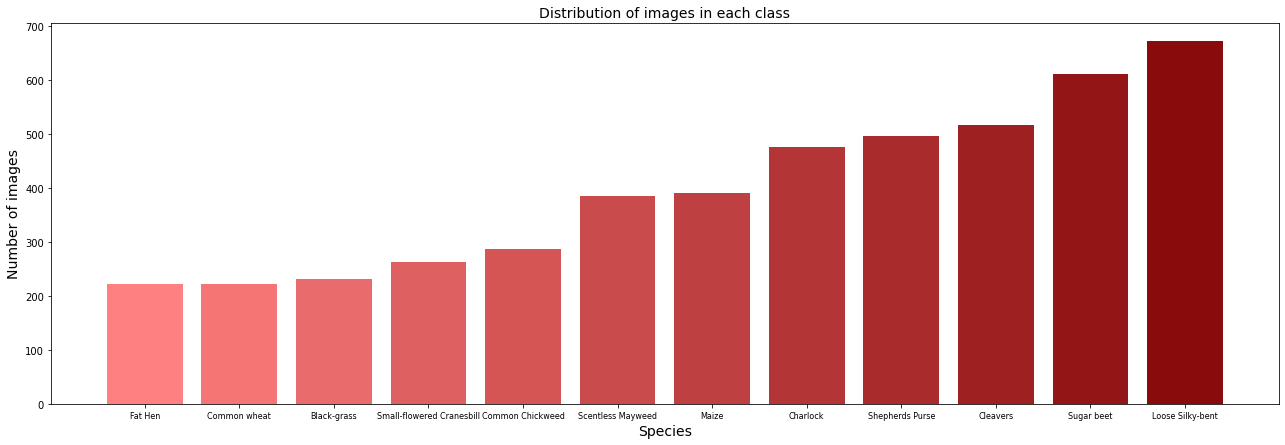

In [13]:
#Viewing the distribution of number of images in each class
values_r =[]
labels_r=[]
for label in set(classes_rdata):
  values_r.append(len(images_r[classes_rdata == label]))
  labels_r.append(label)

values_r.sort()

code_r=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels_r, values_r, color=color_map(data_normalizer(code_r)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

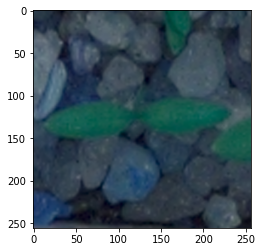

In [14]:
#displaying an image
plt.imshow(images_r[50])

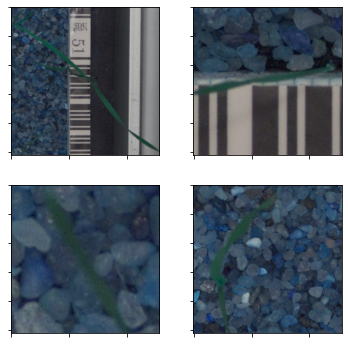

In [15]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images_r =images_r[classes_rdata== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images_r[n])
            n += 1 
plot_for_class("Black-grass")

In [16]:
img = cv2.imread("train/Black-grass/05eedce4d.png")

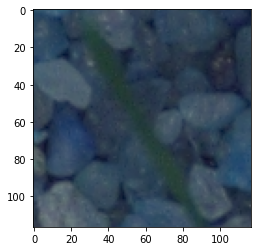

In [17]:
plt.imshow(img)

In [18]:
#Image classification
#Image preprocessing
#pre-processing is an improvement of the image data that suppresses unwilling distortions.It enhances some image features important for further processing.


In [19]:
#Converting images from RGB to HSV and applying mophological transformations
def mask_for_plant(image):
    image_hsv_r = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity_r = 35
    lower_hsv_r = np.array([60 - sensitivity_r, 100, 50])
    upper_hsv_r = np.array([60 + sensitivity_r, 255, 255])

    mask_r = cv2.inRange(image_hsv_r, lower_hsv_r, upper_hsv_r)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask_r = cv2.morphologyEx(mask_r, cv2.MORPH_CLOSE, kernel)
    
    return mask_r

In [20]:
#segmentation to image

def segment_plant_r(image):
    mask_r = mask_for_plant(image)
    output_r = cv2.bitwise_and(image, image, mask = mask_r)
    return output_r

In [21]:
#Applying Sharpening to image

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [22]:
#combine all functions above
def preprocess(img):
  image_segmented = segment_plant_r(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images_r):
  try:
    images_r[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

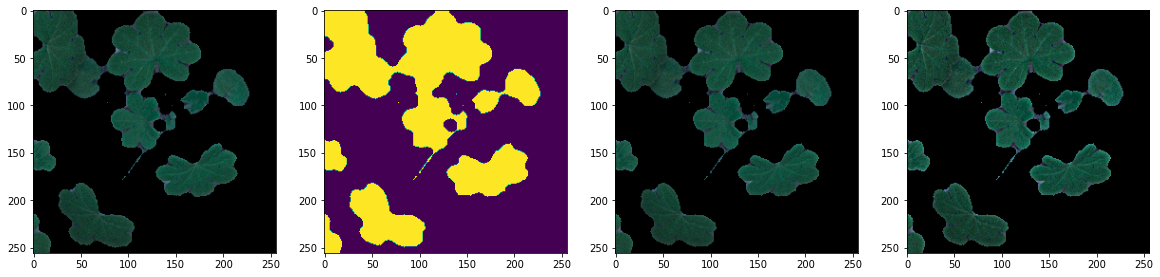

In [23]:
#Viewing the pre-processed images

images_r = np.array(images_r).astype(np.uint8)
classes_rdata = np.array(classes_rdata)
image = images_r[classes_rdata == "Small-flowered Cranesbill"][40]

image_mask = mask_for_plant(image)
image_segmented = segment_plant_r(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [24]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])
number_of_columns = images_r[1].shape[0] * images_r[1].shape[1]
print(number_of_columns)

65536


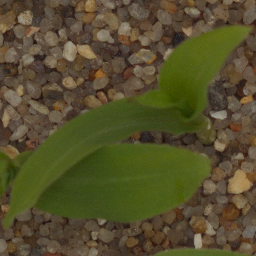

The shape of image to be predicted is:'(578, 578, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 256, 256, 3)'


In [25]:
#Reading the image to predict
from google.colab.patches import cv2_imshow

img_predict = cv2.imread('/content/drive/MyDrive/greatlearningdata/Seedling - Prediction/Predict.png')
img_pred_resized = cv2.resize(img_predict,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resized)
img_predict_r = np.expand_dims(img_pred_resized, axis=0)
print(f"The shape of image to be predicted is:'{img_predict.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict_r.shape}'")

In [26]:
img_predict_r1= img_predict_r.reshape((img_predict_r.shape[0], -1))

In [27]:
#Encoding the target variables
encoder = LabelEncoder()
y = encoder.fit_transform(classes_rdata)

num_classes_r = len(np.unique(y))
num_classes_r


12

In [28]:
#splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(images_r, y, test_size=0.3, random_state=50)

In [29]:
#Creating the validation data from the test data
random_seed = 7
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [30]:
#determing the shapes of target variables and other remaining variables of the training, testing and validation. i.e- shape of x_traun, x_test, y_train,y_test, x_val, y_val.
print(f" Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")
print(f" Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

 Shapes of Train, Test and Validation sets are: (3336, 256, 256, 3),(715, 256, 256, 3),(716, 256, 256, 3)
 Shapes of Train, Test and Validation sets of Target are: (3336,),(715,),(716,)


In [31]:
#2.Design, train tune and test the best AIML image classifier model using:
#Supervised learning algorithms 
#Neural networks 
#CNN


In [32]:
#Classification using supervised learning algorithms
#1. Random forest
#performing PCA to  linearly transform the data such that most of the information in the data is contained within a smaller number of features called components.
def flat_1(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [33]:
X_train_r, X_train_g, X_train_b =flat_1(X_train)
X_test_r, X_test_g, X_test_b = flat_1(X_test)
X_val_r, X_val_g, X_val_b = flat_1(X_val)

In [34]:
#determing shape
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((716, 65536), (716, 65536), (716, 65536))

In [35]:
#Transforming using PCA
n_components = 20
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [36]:
#using transform function
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [37]:
#calculating the explained ratio sum for the above created variables
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()


(0.48007588930055495, 0.5981776478025246, 0.566398053514384)

In [38]:
#concatenating the Xr_train_pca, Xg_train_pca,Xb_train_pca.
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
#concatenating the Xr_test_pca, Xg_test_pca,Xb_test_pca.
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
#concatenating the Xr_val_pca, Xg_val_pca,Xb_val_pca.
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)


In [39]:
#training using random forest classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)
model.fit(X_train_pca,y_train)
y_pred_rf = model.predict(X_test_pca)

In [40]:
#confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_rf))
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_rf))

[[ 0  0  0  1  0  2 34  0  0  0  0  1]
 [ 0 45 10  0  0  4  1  0  5  1  4  1]
 [ 0 16  9  1  0  6  3  0  5  0  4  1]
 [ 0  2  0 63  0  6  4  7  4  5  0  5]
 [ 0  0  1  1  0  2 20  0  4  0  0  6]
 [ 0  6  0  9  0 25 13  0  6  6  2  9]
 [ 1  0  0  7  0  3 83  0  0  0  1  1]
 [ 0  5  0  5  0  2  2  4  3  1  1  4]
 [ 0 12  1  4  0  6  2  8 16  0  0 11]
 [ 0  4  1 10  0  2  1  1 10  9  2  1]
 [ 0  8  3  3  0  5  5  0  1  0 49  2]
 [ 1  3  2 10  0 12  7  0  5  0  6  9]]
0.43636363636363634


From the above, it is evident that the accuracy of the model with random forest classifier is about 43%.

In [41]:
pred_img = np.squeeze(img_predict_r, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)
#Prediction using random forest
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [42]:
rf_score_1 = model.score(X_val_pca, y_val)

rf_accuracy_1 = metrics.accuracy_score(y_test, y_pred_rf)
pred_rf_1 = model.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf_1}'")

The predicted label is:'1'


In [43]:
model_performance = model_performance.append({'Model':'RF',
                                              'Accuracy': rf_accuracy_1,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf_1                                      
                                              }, ignore_index=True)

In [44]:
#Tuning

In [45]:
#Gridsearch CV

In [46]:
#Fitting the data using Random forest
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [47]:
pred_img = np.squeeze(img_predict_r, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [48]:
#Prediction using random forest
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [49]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'1'


In [50]:
print("Accuracy with random forest :", rf_accuracy)

Accuracy with random forest : 0.4433566433566434


From the above, it can be determined that the accuracy of the model with gridsearchCV and random forest classifier is about 42%.

In [51]:
model_performance = model_performance.append({'Model':'RF with GridsearchCV',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)




In [52]:
model_performance

,Model,Accuracy,Loss,Predicted Class
0,RF,0.436364,NA,1
1,RF with GridsearchCV,0.443357,NA,1


In [53]:
#SVM
classifier = svm.SVC(kernel='linear')


In [54]:
#Training and fitting
classifier.fit(X_train_pca, y_train) 

SVC(kernel='linear')

In [55]:
#Testing
prediction_SVM_all = classifier.predict(X_test_pca)

In [56]:
svm_accuracy = metrics.accuracy_score(y_test, prediction_SVM_all)
pred_svm_r = classifier.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm_r}'")

The predicted label is:'1'


In [57]:
#Accuracy with SVM
print("Accuracy of the model with SVM classifier:",svm_accuracy)

Accuracy of the model with SVM classifier: 0.22937062937062938


In [58]:
#Tuning with gridsearchCv
param_grid_svm = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [59]:
svc = SVC()


In [60]:
clf_svm = GridSearchCV(svc, param_grid_svm, verbose=10, n_jobs=-1)


In [61]:
clf_svm.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [62]:
#Testing
svm_score_1 = clf_svm.score(X_val_pca, y_val)
y_pred_r1 = clf_svm.predict(X_test_pca)
svm_accuracy_r1 = metrics.accuracy_score(y_test, y_pred_r1)

In [63]:
pred_img_svm = np.squeeze(img_predict_r, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img_svm)
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)
pred_svm_r2 = clf_svm.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm_r2}'")

The predicted label is:'11'


In [64]:
print("Score with SV classifier:",svm_score_1)
print("Accuracy with SV classifier:",svm_accuracy_r1)

Score with SV classifier: 0.34497206703910616
Accuracy with SV classifier: 0.27132867132867133


From the above models defined above, the Support vector machine with GridsearchCv has more accuracy when compared to the normal SVM classifier.

In [65]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm_r                                      
                                              }, ignore_index=True)
model_performance = model_performance.append({'Model':'SVM with GridsearchCV',
                                              'Accuracy': svm_accuracy_r1,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm_r2                                      
                                              }, ignore_index=True)


In [66]:
#DECISION TREE
# import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
# instantiate the DecisionTreeClassifier model with criterion gini index

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)


# fit the model
clf_gini.fit(X_train_pca, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [67]:
#Predict the Test set results with criterion gini index
y_pred_gini = clf_gini.predict(X_test_pca)
#Check accuracy score with criterion gini index
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.1552


In [68]:
#accuracy checking
y_pred_train_gini = clf_gini.predict(X_train_pca)

y_pred_train_gini
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))



Training-set accuracy score: 0.4604


In [69]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(X_train_pca, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test_pca, y_test)))

Training set score: 0.4604
Test set score: 0.1552


From the above, it can be determined that the accuracy of the decision tree classifier is very low i.e- 15%

In [70]:
#Tuning
from sklearn.tree import DecisionTreeClassifier
param_grid_dt = [
              {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}
              ]
dt = DecisionTreeClassifier()
clf_dt = GridSearchCV(dt, param_grid_dt, verbose=10, n_jobs=-1)
clf_dt.fit(X_train_pca,y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]}],
             verbose=10)

In [71]:
dt_score = clf_dt.score(X_val_pca, y_val)
y_pred_dt = clf_dt.predict(X_test_pca)
dt_accuracy = metrics.accuracy_score(y_test, y_pred_dt)
pred_dt = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_dt}'")

model_performance = model_performance.append({'Model':'DT with gridsearchCV',
                                              'Accuracy': dt_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)
model_performance = model_performance.append({'Model':'DT',
                                              'Accuracy': format(accuracy_score(y_test, y_pred_gini)),
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)


model_performance

The predicted label is:'1'


,Model,Accuracy,Loss,Predicted Class
0,RF,0.436364,NA,1
1,RF with GridsearchCV,0.443357,NA,1
2,SVM,0.229371,NA,1
3,SVM with GridsearchCV,0.271329,NA,11
4,DT with gridsearchCV,0.21958,NA,1
5,DT,0.15524475524475526,NA,1


From the above, it can be determined that the accuracy of the Random forest classifier model is the highest with a score of 43%.




In [72]:
#Classification using ANN
#importing required libraries
import itertools
import tensorflow
from tensorflow.python.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Flatten
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical  # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [73]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [74]:
from sklearn.preprocessing import LabelBinarizer
enc1 = LabelBinarizer()
y5 = enc1.fit_transform(classes_rdata)

In [75]:
y5[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [76]:
#splitting training and testing data
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(images_r, y5, test_size=0.3, random_state=50)

In [77]:
random_seed = 2
X_test1, X_val1, y_test1, y_val1 = train_test_split(X_test1,y_test1, test_size = 0.5, random_state=random_seed)

In [78]:
#shape of training set
print("shape of training set:",X_train1.shape)

shape of training set: (3336, 256, 256, 3)


In [79]:
#reshaping the train and test
X_train1 = X_train1.reshape((X_train1.shape[0], -1))
X_test1 = X_test1.reshape((X_test1.shape[0], -1))

In [80]:
#shape of train and test
print("Shape of training and testing:",X_train1.shape,X_test1.shape)

Shape of training and testing: (3336, 196608) (715, 196608)


In [81]:
y_test1.shape

(715, 12)

In [82]:
y_train1.shape

(3336, 12)

In [83]:
#shape of y_train and y_test
print("Shape of y_train and y_test:", y_train1.shape,y_test1.shape)

Shape of y_train and y_test: (3336, 12) (715, 12)


In [84]:
X_val1.shape

(716, 256, 256, 3)

In [85]:
X_val1 = X_val1.reshape((X_val1.shape[0], -1))

In [86]:
print("Shape of x_val1:",X_val1.shape)

Shape of x_val1: (716, 196608)


In [87]:
y_val1.shape

(716, 12)

In [88]:
#Fitting ANN model
from tensorflow.keras.layers import Activation, Dense
model = Sequential()
model.add(Dense(50, input_shape = (196608, )))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(12))
model.add(Activation('softmax'))


In [89]:
#Compiling the model
from tensorflow.keras import optimizers
sgd = optimizers.SGD(learning_rate = 0.01)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [90]:
history = model.fit(X_train1, y_train1, batch_size = 20, epochs = 10, verbose = 1)

Epoch 1/10
167/167 [==============================] - 3s 5ms/step - loss: 2.4608 - accuracy: 0.1295
Epoch 2/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4090 - accuracy: 0.1460
Epoch 3/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4057 - accuracy: 0.1463
Epoch 4/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4053 - accuracy: 0.1466
Epoch 5/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4041 - accuracy: 0.1463
Epoch 6/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4034 - accuracy: 0.1463
Epoch 7/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4022 - accuracy: 0.1484
Epoch 8/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4015 - accuracy: 0.1466
Epoch 9/10
167/167 [==============================] - 1s 5ms/step - loss: 2.4003 - accuracy: 0.1490
Epoch 10/10
167/167 [==============================] - 1s 5ms/step - loss: 2.3991 - accuracy: 0.1610

From the above model, it can be defined that the loss is 2.38 and the accuracy is about 15%

In [91]:
#Evaluation of the model
results = model.evaluate(X_test1, y_test1)

23/23 [==============================] - 0s 5ms/step - loss: 2.3974 - accuracy: 0.1371


In [92]:
#Accuracy of the model
print('Test accuracy: ', results[1])

Test accuracy:  0.1370629370212555


In [93]:
#Tuning
# include Weight initialization, batch normalization, non-linear activation function 'relu' and dropout layer

Weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree

Sigmoid functions suffer from gradient vanishing problem, making training slower

There are many choices apart from sigmoid and tanh.

'relu' (rectified linear unit) is one of the most popular ones

Batch Normalization, one of the methods to prevent the "internal covariance shift" problem, has proven to be highly effective

Normalize each mini-batch before nonlinearity

In [94]:
from tensorflow.keras.layers import BatchNormalization, Dropout

Batch normalization layer is usually inserted after dense/convolution and before nonlinearity

In [95]:
def model_p():
    model7 = Sequential()
    
    model7.add(Dense(50, input_shape = (196608, ), kernel_initializer='he_normal'))
    model7.add(BatchNormalization())
    model7.add(Activation('relu'))
    model7.add(Dropout(0.2))
    model7.add(Dense(50, kernel_initializer='he_normal'))
    model7.add(BatchNormalization())
    model7.add(Activation('relu'))    
    model7.add(Dropout(0.2))
    model7.add(Dense(50, kernel_initializer='he_normal'))
    model7.add(BatchNormalization())
    model7.add(Activation('relu'))
    model7.add(Dropout(0.2))
    model7.add(Dense(50, kernel_initializer='he_normal'))
    model7.add(BatchNormalization())
    model7.add(Activation('relu'))
    model7.add(Dropout(0.2))
    model7.add(Dense(12, kernel_initializer='he_normal'))
    model7.add(Activation('softmax'))
    
    adam_7 = optimizers.Adam(lr = 0.001)
    model7.compile(optimizer = adam_7, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model7

In [96]:
model_u = model_p()
history_u = model_u.fit(X_train1, y_train1,validation_data=(X_test1,y_test1),epochs = 10, verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
105/105 [==============================] - 3s 12ms/step - loss: 2.5130 - accuracy: 0.1808 - val_loss: 2.1541 - val_accuracy: 0.2797
Epoch 2/10
105/105 [==============================] - 1s 9ms/step - loss: 2.0685 - accuracy: 0.3019 - val_loss: 1.7601 - val_accuracy: 0.3902
Epoch 3/10
105/105 [==============================] - 1s 9ms/step - loss: 1.8607 - accuracy: 0.3552 - val_loss: 1.5783 - val_accuracy: 0.4685
Epoch 4/10
105/105 [==============================] - 1s 9ms/step - loss: 1.7273 - accuracy: 0.4107 - val_loss: 1.4626 - val_accuracy: 0.5147
Epoch 5/10
105/105 [==============================] - 1s 9ms/step - loss: 1.6102 - accuracy: 0.4487 - val_loss: 1.4191 - val_accuracy: 0.5273
Epoch 6/10
105/105 [==============================] - 1s 9ms/step - loss: 1.5122 - accuracy: 0.4838 - val_loss: 1.3540 - val_accuracy: 0.5497
Epoch 7/10
105/105 [==============================] - 1s 9ms/step - loss: 1.4257 - accuracy: 0.5147 - val_loss: 1.3079 - val_accuracy: 0.5748
Epoch

In [97]:
#Evaluate model

In [98]:
results_t = model_u.evaluate(X_test1, y_test1)

23/23 [==============================] - 0s 5ms/step - loss: 1.1760 - accuracy: 0.6014


In [99]:
print('Test accuracy: ', results_t[1])

Test accuracy:  0.6013985872268677


In [100]:
ann_loss, ann_accuracy = model_u.evaluate(X_test1, y_test1, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

23/23 [==============================] - 0s 5ms/step - loss: 1.1760 - accuracy: 0.6014
Test loss: 1.175961971282959
Test accuracy: 0.6013985872268677


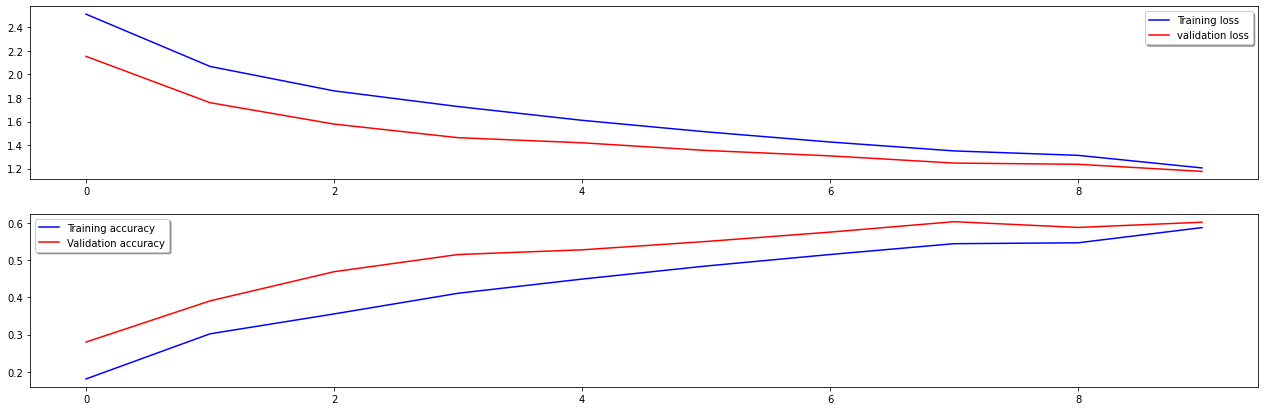

In [101]:
#Model Evaluation for testing dataset
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history_u.history['loss'], color='b', label="Training loss")
ax[0].plot(history_u.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_u.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_u.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

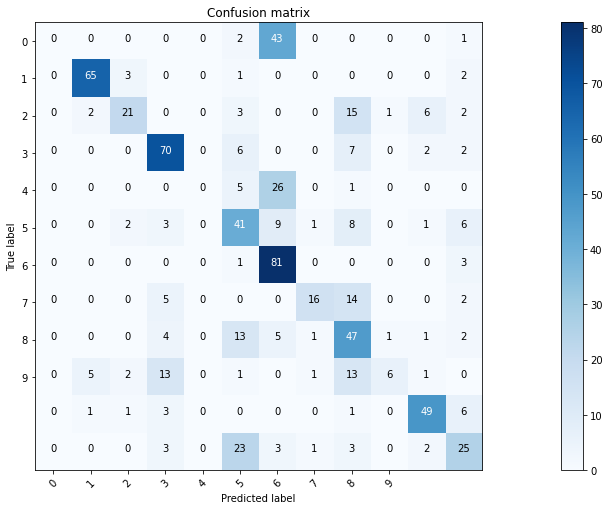

In [102]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the  dataset
Y_predu = model_u.predict(X_val1)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_predu,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val1,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


In [103]:
ann_predict = np.argmax(model_u.predict(img_predict_r1))

In [104]:
print('The predicted  with label:', ann_predict)

The predicted  with label: 1


In [105]:
model_performance1 = model_performance.append({'Model':'ANN with batchnormalization, dropout and weight initialization',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance1

,Model,Accuracy,Loss,Predicted Class
0,RF,0.436364,NA,1
1,RF with GridsearchCV,0.443357,NA,1
2,SVM,0.229371,NA,1
3,SVM with GridsearchCV,0.271329,NA,11
4,DT with gridsearchCV,0.21958,NA,1
5,DT,0.15524475524475526,NA,1
6,"ANN with batchnormalization, dropout and weigh...",0.601399,1.17596,1


In [106]:
#Classification with CNN

In [107]:
#importing required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [108]:
#Building the CNN
#shape of X_train and y_train
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3336, 256, 256, 3)
(3336,)
(715, 256, 256, 3)
(715,)


Reshape train and test sets into compatible shapes

1.Sequential model in tensorflow.keras expects data to be in the format (n_e, n_h, n_w, n_c)
2.n_e= number of examples, n_h = height, n_w = width, n_c = number of channels
3.do not reshape labels

In [109]:
X_train = X_train.reshape(X_train.shape[0], 256, 256, 3)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 3)

Normalize data

1.we must normalize our data as it is always required in neural network models

2.we can achieve this by dividing the RGB codes with 255 (which is the maximum RGB code minus the minimum RGB code)

3.normalize X_train and X_test

4.make sure that the values are float so that we can get decimal points after division

In [110]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [111]:
print("X_train shape:", X_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_test:", X_test.shape[0])
print("Max value in X_train:", X_train.max())
print("Min value in X_train:", X_train.min())

X_train shape: (3336, 256, 256, 3)
Images in X_train: 3336
Images in X_test: 715
Max value in X_train: 1.0
Min value in X_train: 0.0


In [112]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=12)
y_test = to_categorical(y_test, num_classes=12)

print("Shape of y_train:", y_train.shape)
print("One value of y_train:", y_train[0])

Shape of y_train: (3336, 12)
One value of y_train: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [113]:
#building the CNN
#Vanilla CNN + Pooling + Dropout


In [114]:
#Initialize a sequential model again
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D

# Initialize the model
model_c = Sequential()

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu' 
model_c.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(256, 256, 3)))

# Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'relu' 
model_c.add(Conv2D(filters=32, kernel_size=3, activation="relu"))

# Add a MaxPooling Layer of size 2X2 
model_c.add(MaxPooling2D(pool_size=(2, 2)))

# Apply Dropout with 0.2 probability 
model_c.add(Dropout(rate=0.2))

# Flatten the layer
model_c.add(Flatten())

# Add Fully Connected Layer with 128 units and activation function as 'relu'
model_c.add(Dense(128, activation="relu"))

#Add Fully Connected Layer with 12 units and activation function as 'softmax'
model_c.add(Dense(12, activation="softmax"))

In [115]:
# Compile the model
model_c.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Use earlystopping
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.01)

# Fit the model
model_c.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
105/105 [==============================] - 14s 64ms/step - loss: 1.6118 - accuracy: 0.4790 - val_loss: 1.3283 - val_accuracy: 0.5720
Epoch 2/10
105/105 [==============================] - 6s 56ms/step - loss: 0.5587 - accuracy: 0.8216 - val_loss: 0.9941 - val_accuracy: 0.6923
Epoch 3/10
105/105 [==============================] - 6s 56ms/step - loss: 0.0458 - accuracy: 0.9907 - val_loss: 1.2406 - val_accuracy: 0.6685
Epoch 4/10
105/105 [==============================] - 6s 56ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 1.4456 - val_accuracy: 0.6615


In [116]:
#Calculating loss and accuracy
model_c.evaluate(X_test, y_test)

23/23 [==============================] - 0s 18ms/step - loss: 1.4456 - accuracy: 0.6615


[1.4456300735473633, 0.6615384817123413]

In [117]:
cnn_loss1, cnn_accuracy1 = model_c.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss1)
print('Test accuracy:', cnn_accuracy1)

23/23 [==============================] - 0s 18ms/step - loss: 1.4456 - accuracy: 0.6615
Test loss: 1.4456300735473633
Test accuracy: 0.6615384817123413


In [118]:
cnn_predict = np.argmax(model_c.predict(img_predict_r))

In [119]:
model_performance1 = model_performance1.append({'Model':'CNN with dropout',
                                              'Accuracy': cnn_accuracy1,
                                              'Loss': cnn_loss1,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

model_performance1

,Model,Accuracy,Loss,Predicted Class
0,RF,0.436364,NA,1
1,RF with GridsearchCV,0.443357,NA,1
2,SVM,0.229371,NA,1
3,SVM with GridsearchCV,0.271329,NA,11
4,DT with gridsearchCV,0.21958,NA,1
5,DT,0.15524475524475526,NA,1
6,"ANN with batchnormalization, dropout and weigh...",0.601399,1.17596,1
7,CNN with dropout,0.661538,1.44563,1


In [120]:
#CNN with data augumentation

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D

classifier = None
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (256,256, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Flatten())
classifier.add(Dense(activation = 'relu', units=512))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'relu', units=256))
classifier.add(BatchNormalization(axis = -1))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation = 'sigmoid', units=12))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(classifier.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)      

In [122]:
X_traini, X_testi, y_traini, y_testi = train_test_split(images_r,y, test_size = 0.20, random_state = 0)

In [123]:
from tensorflow.keras.utils import to_categorical

y_traini = to_categorical(y_traini, num_classes=12)
y_testi = to_categorical(y_testi, num_classes=12)

print("Shape of y_train:", y_traini.shape)
print("One value of y_train:", y_traini[0])

Shape of y_train: (3813, 12)
One value of y_train: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [124]:
history = classifier.fit(X_traini, 
                         y_traini, 
                         batch_size = 64, 
                         verbose = 2, 
                         epochs = 50, 
                         validation_data=(X_testi,y_testi),
                         shuffle = False)

Epoch 1/50
60/60 - 6s - loss: 1.6022 - accuracy: 0.5059 - val_loss: 3.3396 - val_accuracy: 0.3323 - 6s/epoch - 102ms/step
Epoch 2/50
60/60 - 3s - loss: 0.4649 - accuracy: 0.8560 - val_loss: 1.2307 - val_accuracy: 0.6027 - 3s/epoch - 56ms/step
Epoch 3/50
60/60 - 3s - loss: 0.1376 - accuracy: 0.9651 - val_loss: 1.1949 - val_accuracy: 0.6373 - 3s/epoch - 56ms/step
Epoch 4/50
60/60 - 3s - loss: 0.0603 - accuracy: 0.9877 - val_loss: 1.4275 - val_accuracy: 0.5933 - 3s/epoch - 56ms/step
Epoch 5/50
60/60 - 3s - loss: 0.0206 - accuracy: 0.9974 - val_loss: 1.7319 - val_accuracy: 0.5157 - 3s/epoch - 56ms/step
Epoch 6/50
60/60 - 3s - loss: 0.0091 - accuracy: 0.9995 - val_loss: 2.3678 - val_accuracy: 0.4560 - 3s/epoch - 57ms/step
Epoch 7/50
60/60 - 3s - loss: 0.0051 - accuracy: 0.9997 - val_loss: 3.1421 - val_accuracy: 0.3763 - 3s/epoch - 57ms/step
Epoch 8/50
60/60 - 3s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 3.3989 - val_accuracy: 0.3658 - 3s/epoch - 57ms/step
Epoch 9/50
60/60 - 3s - loss: 0

In [125]:
#Data augmentation

In [126]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale = 1/255,
                                     zoom_range = 0.3,
                                     horizontal_flip = True,
                                     rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(X_traini,
                                       y_traini,
                                       batch_size = 8,
                                       shuffle = False)

test_generator = test_generator.flow(X_testi,
                                     y_testi,
                                     batch_size = 8,
                                     shuffle = False)


In [127]:
classifier.fit(train_generator,
                                   steps_per_epoch = len(X_traini)/8,
                                   epochs = 10,
                                   shuffle = False)

Epoch 1/10
476/476 [==============================] - 54s 111ms/step - loss: 1.9062 - accuracy: 0.4104
Epoch 2/10
476/476 [==============================] - 52s 109ms/step - loss: 1.4180 - accuracy: 0.5227
Epoch 3/10
476/476 [==============================] - 52s 110ms/step - loss: 1.2793 - accuracy: 0.5644
Epoch 4/10
476/476 [==============================] - 54s 114ms/step - loss: 1.1530 - accuracy: 0.6029
Epoch 5/10
476/476 [==============================] - 53s 111ms/step - loss: 1.0751 - accuracy: 0.6302
Epoch 6/10
476/476 [==============================] - 53s 110ms/step - loss: 0.9805 - accuracy: 0.6638
Epoch 7/10
476/476 [==============================] - 52s 110ms/step - loss: 0.9840 - accuracy: 0.6622
Epoch 8/10
476/476 [==============================] - 53s 111ms/step - loss: 0.9025 - accuracy: 0.6911
Epoch 9/10
476/476 [==============================] - 53s 110ms/step - loss: 0.8288 - accuracy: 0.7228
Epoch 10/10
476/476 [==============================] - 53s 111ms/step - l

In [128]:
print("Test_Accuracy(after augmentation): {:.2f}%".format(classifier.evaluate(test_generator, steps = len(X_testi)/8, verbose = 1)[1]*100))

119/119 [==============================] - 1s 9ms/step - loss: 0.7306 - accuracy: 0.7453
Test_Accuracy(after augmentation): 74.53%


From the above, it can be determined that the classifier model has the highest accuracy of 79% and loss of 0.79

In [129]:
#checking accuracy, loss
cnn_loss2, cnn_accuracy2 = classifier.evaluate(test_generator, steps = len(X_testi)/8, verbose = 1)
print('Test loss:', cnn_loss2)
print('Test accuracy:', cnn_accuracy2)


119/119 [==============================] - 1s 8ms/step - loss: 0.7306 - accuracy: 0.7453
Test loss: 0.7306336760520935
Test accuracy: 0.7452830076217651


In [139]:
#predicting the image
cnn_predict3=classifier.predict(img_predict_r)
cnn_predict3


array([[1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.]], dtype=float32)

In [131]:
#3.Compare the results from the above step along with your detailed observations on the best performing algorithm and why/how it outperforms other algorithms in this case.

In [132]:
#comparing the results
model_performance1 = model_performance1.append({'Model':'CNN after data augmentation',
                                              'Accuracy': cnn_accuracy2,
                                              'Loss': cnn_loss2,
                                              'Predicted Class': cnn_predict3                                      
                                              }, ignore_index=True)

model_performance1

,Model,Accuracy,Loss,Predicted Class
0,RF,0.436364,NA,1
1,RF with GridsearchCV,0.443357,NA,1
2,SVM,0.229371,NA,1
3,SVM with GridsearchCV,0.271329,NA,11
4,DT with gridsearchCV,0.21958,NA,1
5,DT,0.15524475524475526,NA,1
6,"ANN with batchnormalization, dropout and weigh...",0.601399,1.17596,1
7,CNN with dropout,0.661538,1.44563,1
8,CNN after data augmentation,0.745283,0.730634,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,..."


1.Convolution Neural Networks outperforms Neural Networks and which in turn out perform Supervised Learning models.

2. The best part of CNNs is high accuracy of image prediction and less loss. 
3. we do not have to do feature extraction. The system learns to do feature extraction and the core concept of CNN is, it uses convolution of image and filters to generate invariant features which are passed on to the next layer.
4. The features in the next layer are convoluted with different filters to generate more invariant and abstract features and the process continues till one gets final feature / output which is invariant to occlusions. 
5. ANNs are better than Supervised Learning models because we don't have to perform feature extraction in ANNS.
6. whereas in Supervised Learning, we must perform the Principal component analysis (PCA) to compute the principal components in images.

In predicting the Plant Seedlings dataset, we can see that the accuracy of Support Vector Machines, Random Forest and Decision Tree models are less than 45%. Using ANNs, the accuracy increased to 60% with a loss of about 2.5. This was improved much more by using CNNs. The accuracy increased to approximately 79% with less loss of 0.8.

Hence, classifier the CNN model performed with data augmentation is the best model with layers such as dropout, non-linearity, conv2D.


In [133]:
#4.Pickle the best performing  model

In [134]:
import pickle
Pkl_Filename = "Pickle_RR_Model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(classifier, file)

INFO:tensorflow:Assets written to: ram://03e30cd5-9f0c-4140-bfa6-f8ff93303dc5/assets


In [135]:
#5.Import the the test image [ from the “ Prediction” folder ] to predict the class. Display the image. Use the best trained image classifier model to predict the class.

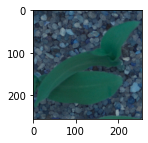

Prediction for above image:  [[1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]]


In [136]:
plt.figure(figsize=(2,2))
plt.imshow(img_pred_resized)
plt.show()
print("Prediction for above image: ",classifier.predict(img_predict_r))


In [137]:
#converting ipynb file to html file
!pip install nbconvert


In [138]:
#!jupyter nbconvert --to html  /content/ComputerVisionProject.ipynb